In [2]:
import torch
from torch import nn

torch.__version__

'2.0.0a0'

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [8]:
# always start small and increase when necessary
# ml is an iterative process

In [17]:
import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
images_path = data_path / "pizza_steak_sushi"

if images_path.is_dir():
    print(f"{images_path} directory exists.")
else:
    print(f"Did not find {images_path} directory, creating one...")
    images_path.mkdir(parents=True, exist_ok=True)
    
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(images_path)

data/pizza_steak_sushi directory exists.


In [11]:
# now, become one with the data!

In [18]:
import os
def walk_through_dir(dir_path: str):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
walk_through_dir(images_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.


In [19]:
train_dir = images_path / "train"
test_dir = images_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [21]:
# now visualize, visualize, visualize!

Random image pat: data/pizza_steak_sushi/test/pizza/195160.jpg
Image class: pizza
CHW: RGB, 384, 512


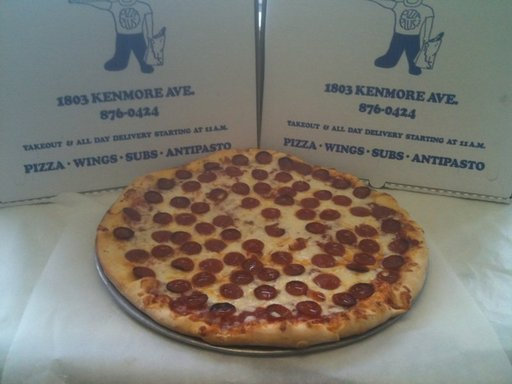

In [34]:
import random
from PIL import Image # python image library

random.seed(42)

images_path_list = list(images_path.glob("*/*/*.jpg"))

random_image_path = random.choice(images_path_list) # get a random image file from all the imgs

image_class = random_image_path.parent.stem # parent dir name

img = Image.open(random_image_path)

print(f"Random image pat: {random_image_path}")
print(f"Image class: {image_class}")
print(f"CHW: {img.mode}, {img.height}, {img.width}")
img

In [35]:
# to be able to compute with we need to 
# 1. turn data in tensors 
# 2. turn it into Dataset and DataLoader

In [44]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import datasets, transforms # transforms is for formatting images
# data augmentation: the practice of altering data to make it harder for a model to learn

In [39]:
data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5), # 50% probability of flip
    transforms.ToTensor() # pixel values to 0-255 and between 0.0 and 1.0
])

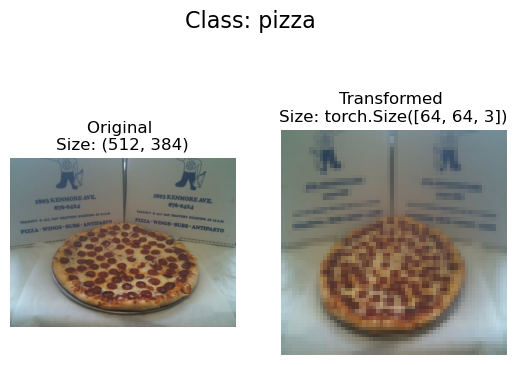

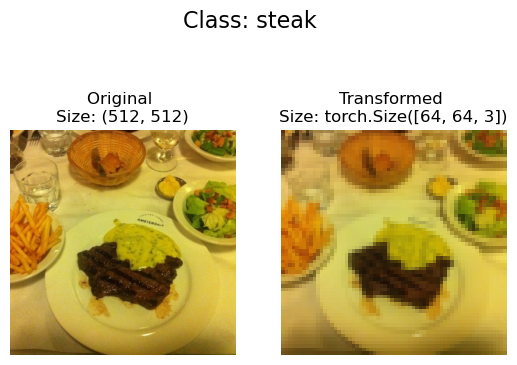

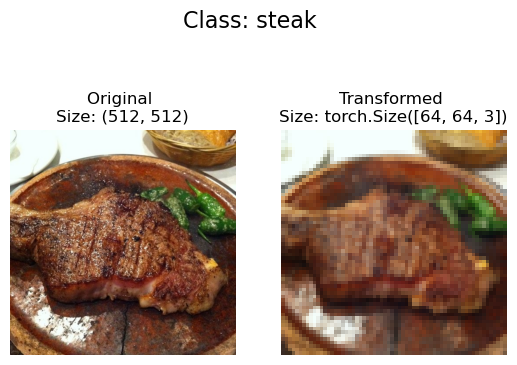

In [45]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")
            
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")
            
            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(images_path_list,
                       transform=data_transform,
                       n=3)

In [47]:
# more pixels in an image allows for more data to train on, 
# but also more computation required

In [61]:
# turn data into a torch Dataset
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                 transform=data_transform,
                                 target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [49]:
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [50]:
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [51]:
len(train_data), len(test_data)

(225, 75)

In [59]:
# images are now in 3x64x64 tensors storing floats from 0.0-1.0
train_data[0][0].dtype

torch.float32

Original shape: torch.Size([3, 64, 64]) -> [CHW]
Original shape: torch.Size([64, 64, 3]) -> [CHW]


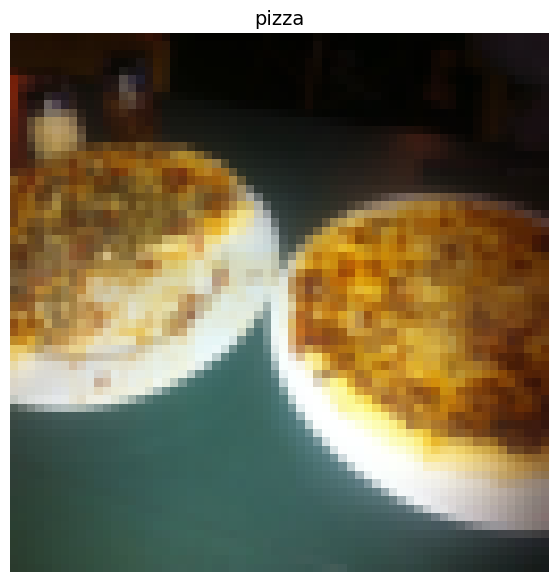

In [60]:
img, label = train_data[0][0], train_data[0][1]
img_permute = img.permute(1, 2, 0)

print(f"Original shape: {img.shape} -> [CHW]")
print(f"Original shape: {img_permute.shape} -> [CHW]")

plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);

In [62]:
# Turn torch Dataset into a Dataloader (makes the samples iterable)